In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install timm==0.9.16
!git clone https://github.com/NVlabs/FasterViT.git
!pip install -r FasterViT/requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall:

In [4]:
import sys
sys.path.append("/kaggle/working/FasterViT")


In [5]:
from fastervit import create_model
import timm

print("timm version:", timm.__version__)
print("FasterViT loaded successfully!")


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

timm version: 0.9.16
FasterViT loaded successfully!


In [12]:
import os
import math
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from fastervit import create_model

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ---------- experiment config ----------
RUN_NAME = "fvit0_oci_cifar10"
CHECKPOINT_DIR = Path("/kaggle/working") / RUN_NAME
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

NUM_CLASSES = 10
BATCH_SIZE = 128           # can go higher if GPU memory allows
NUM_EPOCHS = 75          
BASE_LR = 5e-4
WEIGHT_DECAY = 0.05

SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed_all(SEED)


Device: cuda


In [13]:
# standard CIFAR-10 augmentations + resize to 224
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

data_root = "./data"

train_dataset = datasets.CIFAR10(
    root=data_root, train=True, download=True, transform=train_transform
)
test_dataset = datasets.CIFAR10(
    root=data_root, train=False, download=True, transform=test_transform
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=4, pin_memory=True
)

len(train_dataset), len(test_dataset)


100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s] 


(50000, 10000)

In [18]:
def apply_oci_to_carrier_tokens(model: nn.Module,
                                kernel_size: int = 5) -> nn.Module:
    """
    Overlapping Carrier Initialization (OCI):
    - Find modules that have attribute 'to_global_feature'
      (this is where carrier tokens are initialized in FasterViT).
    - If the first layer is a Conv2d with 3x3 kernel, replace with
      a larger Conv2d (e.g., 5x5) with padding=kernel_size//2.
    - Copy old weights into the center of the new kernel.
    """
    assert kernel_size in (5, 7), "Kernel size typically 5 or 7 for OCI."
    new_modules = 0

    for module_name, module in model.named_modules():
        if hasattr(module, "to_global_feature"):
            tgf = module.to_global_feature

            # handle both direct Conv2d and nn.Sequential cases
            if isinstance(tgf, nn.Conv2d):
                conv = tgf
                seq = None
            elif isinstance(tgf, nn.Sequential) and isinstance(tgf[0], nn.Conv2d):
                conv = tgf[0]
                seq = tgf
            else:
                continue  # not the pattern we expect

            if conv.kernel_size != (3, 3) or conv.stride != (1, 1):   
                continue

            print(f"[OCI] Patching carrier conv in '{module_name}'")

            new_conv = nn.Conv2d(
                in_channels=conv.in_channels,
                out_channels=conv.out_channels,
                kernel_size=kernel_size,    #changed from 3x3 to 5x5/7x7
                stride=conv.stride,
                padding=kernel_size // 2,
                bias=conv.bias is not None,
            )

            # center-initialize from old 3x3 weights
            with torch.no_grad():
                new_conv.weight.zero_()
                kh, kw = conv.kernel_size
                start = kernel_size // 2 - kh // 2
                end = start + kh
                new_conv.weight[:, :, start:end, start:end] = conv.weight
                if conv.bias is not None:
                    new_conv.bias.copy_(conv.bias)

            # plug it back in
            if seq is None:
                module.to_global_feature = new_conv
            else:
                seq[0] = new_conv

            new_modules += 1

    print(f"[OCI] Total carrier initializers patched: {new_modules}")
    return model


In [19]:
def build_fvit0_oci(pretrained_imagenet: bool = False) -> nn.Module:
    """
    Create FasterViT-0, adapt to CIFAR-10, and apply OCI.
    """
    model = create_model(
        "faster_vit_0_224",
        pretrained=pretrained_imagenet,    # you can toggle this later
        num_classes=NUM_CLASSES,
    )
    model = apply_oci_to_carrier_tokens(model, kernel_size=5)
    return model.to(DEVICE)

model = build_fvit0_oci(pretrained_imagenet=False)
print("Number of parameters (M):", sum(p.numel() for p in model.parameters()) / 1e6)


[OCI] Patching carrier conv in 'levels.2.global_tokenizer'
[OCI] Total carrier initializers patched: 1
Number of parameters (M): 32.535626


## Training & evaluation helpers + checkpointing

In [21]:
import shutil

ZIP_EVERY = 5  # zip weights every 5 epochs

def zip_checkpoints():
    zip_base = f"/kaggle/working/{RUN_NAME}_ckpts"
    shutil.make_archive(zip_base, "zip", CHECKPOINT_DIR)
    print(f"[ZIP] Created {zip_base}.zip  --> Download this from the right panel.")


In [23]:
def save_checkpoint(epoch, model, optimizer, scheduler, best_acc, path):
    state = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict() if scheduler is not None else None,
        "best_acc": best_acc,
    }
    torch.save(state, path)
    print(f"[Checkpoint] Saved to {path}")


def load_checkpoint(path, model, optimizer=None, scheduler=None):
    print(f"[Checkpoint] Loading from {path}")
    ckpt = torch.load(path, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state"])
    if optimizer is not None and "optimizer_state" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer_state"])
    if scheduler is not None and ckpt.get("scheduler_state") is not None:
        scheduler.load_state_dict(ckpt["scheduler_state"])
    start_epoch = ckpt.get("epoch", 0) + 1
    best_acc = ckpt.get("best_acc", 0.0)
    return start_epoch, best_acc


def train_one_epoch(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, targets) in enumerate(loader):
        images = images.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    print(f"Train | Epoch {epoch} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion, epoch, split="Val"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, targets in loader:
        images = images.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    print(f"{split} | Epoch {epoch} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc


## Main training loop with resume support and periodic saves

In [28]:
PATIENCE = 10      # or any number you want
ZIP_EVERY = 5      # zip checkpoints every 5 epochs


In [38]:
import shutil

def zip_checkpoints():
    zip_base = f"/kaggle/working/{RUN_NAME}_ckpts"
    shutil.make_archive(zip_base, "zip", CHECKPOINT_DIR)
    print(f"[ZIP] Saved {zip_base}.zip  → Download from right panel.")


In [39]:
def run_training(resume: bool = True):
    model = build_fvit0_oci(pretrained_imagenet=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY
    )
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    ckpt_path = CHECKPOINT_DIR / "latest.pt"
    best_path = CHECKPOINT_DIR / "best.pt"

    start_epoch = 0
    best_acc = 0.0

    # resume if checkpoint exists
    if resume and ckpt_path.exists():
        start_epoch, best_acc = load_checkpoint(
            ckpt_path, model, optimizer, scheduler
        )
        print(f"Resuming from epoch {start_epoch}, best_acc={best_acc:.2f}%")

    for epoch in range(start_epoch, NUM_EPOCHS):
        train_one_epoch(model, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, test_loader, criterion, epoch, split="Val")

        scheduler.step()

        # save latest every epoch
        save_checkpoint(epoch, model, optimizer, scheduler, best_acc, ckpt_path)

        # save best model
        if val_acc > best_acc:
            best_acc = val_acc
            save_checkpoint(epoch, model, optimizer, scheduler, best_acc, best_path)
            print(f"[Best] New best accuracy: {best_acc:.2f}% at epoch {epoch}")

    print("Training finished. Best Val Acc: {:.2f}%".format(best_acc))


run_training(resume=True)


[OCI] Patching carrier conv in 'levels.2.global_tokenizer'
[OCI] Total carrier initializers patched: 1
Train | Epoch 0 | Loss: 1.7523 | Acc: 34.04%
Val | Epoch 0 | Loss: 1.4970 | Acc: 43.65%
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/latest.pt
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/best.pt
[Best] New best accuracy: 43.65% at epoch 0
Train | Epoch 1 | Loss: 1.3378 | Acc: 51.37%
Val | Epoch 1 | Loss: 1.2024 | Acc: 56.66%
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/latest.pt
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/best.pt
[Best] New best accuracy: 56.66% at epoch 1
Train | Epoch 2 | Loss: 1.1060 | Acc: 60.72%
Val | Epoch 2 | Loss: 1.0008 | Acc: 64.49%
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/latest.pt
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/best.pt
[Best] New best accuracy: 64.49% at epoch 2
Train | Epoch 3 | Loss: 0.9963 | Acc: 64.88%
Val | Epoch 3 | Loss: 1.0618 | Acc: 62.80%
[Checkpoint] Saved to /

In [41]:
import json
from pathlib import Path

# --------- paths ----------
RUN_NAME = "fvit0_oci_cifar10"
CHECKPOINT_DIR = Path("/kaggle/working") / RUN_NAME
BEST_CKPT = CHECKPOINT_DIR / "best.pt"

print("Best checkpoint path:", BEST_CKPT)

# --------- rebuild model (with OCI) ----------
model = build_fvit0_oci(pretrained_imagenet=False)  # same as in training
criterion = nn.CrossEntropyLoss()

# --------- load best weights ----------
# load_checkpoint must be the same function you used in training
start_epoch, best_acc_saved = load_checkpoint(
    BEST_CKPT,
    model,
    optimizer=None,
    scheduler=None,
)

print(f"Best val acc stored in ckpt: {best_acc_saved:.2f}% (epoch {start_epoch-1})")

# --------- final evaluation on TEST set ----------
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    epoch="best",
    split="Test (OCI)"
)

print(f"[FasterViT-0 + OCI] Final Test Acc: {test_acc:.2f}%, Test Loss: {test_loss:.4f}")

# --------- save numeric results to file for later comparison ----------
results = {
    "model": "fvit0_oci_cifar10",
    "ckpt_epoch": int(start_epoch - 1),
    "val_best_acc": float(best_acc_saved),
    "test_loss": float(test_loss),
    "test_acc": float(test_acc),
}

results_path = CHECKPOINT_DIR / "results_oci.json"
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print("Saved results to", results_path)


Best checkpoint path: /kaggle/working/fvit0_oci_cifar10/best.pt
[OCI] Patching carrier conv in 'levels.2.global_tokenizer'
[OCI] Total carrier initializers patched: 1
[Checkpoint] Loading from /kaggle/working/fvit0_oci_cifar10/best.pt
Best val acc stored in ckpt: 92.27% (epoch 68)
Test (OCI) | Epoch best | Loss: 0.3074 | Acc: 92.27%
[FasterViT-0 + OCI] Final Test Acc: 92.27%, Test Loss: 0.3074
Saved results to /kaggle/working/fvit0_oci_cifar10/results_oci.json


[OCI] Patching carrier conv in 'levels.2.global_tokenizer'
[OCI] Total carrier initializers patched: 1
[Checkpoint] Loading from /kaggle/working/fvit0_oci_cifar10/best.pt


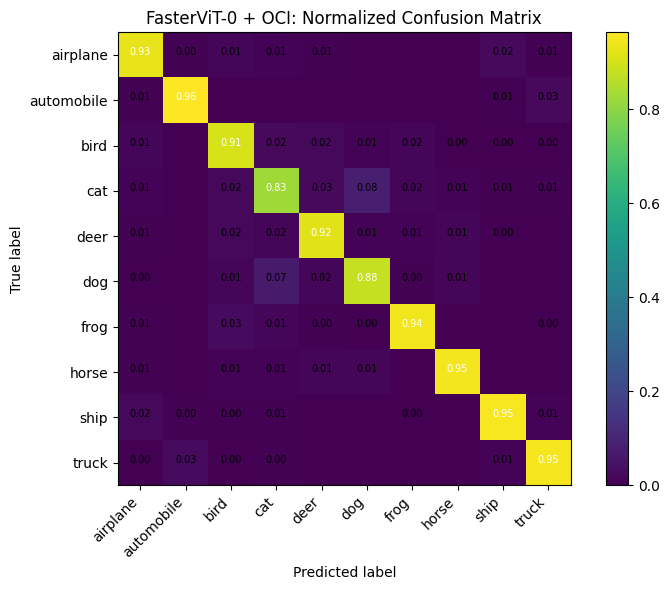

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Make sure best OCI model is loaded:
model = build_fvit0_oci(pretrained_imagenet=False)
_, _ = load_checkpoint(BEST_CKPT, model, optimizer=None, scheduler=None)
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

cm = confusion_matrix(all_targets, all_preds)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

classes = train_dataset.classes  # ['airplane', 'automobile', ...]


plt.figure(figsize=(8, 6))
plt.imshow(cm_norm, interpolation='nearest')
plt.title("FasterViT-0 + OCI: Normalized Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha="right")
plt.yticks(tick_marks, classes)

thresh = cm_norm.max() / 2.
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    val = cm_norm[i, j]
    if val > 0.001:
        plt.text(j, i, f"{val:.2f}",
                 horizontalalignment="center",
                 color="white" if val > thresh else "black",
                 fontsize=7)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


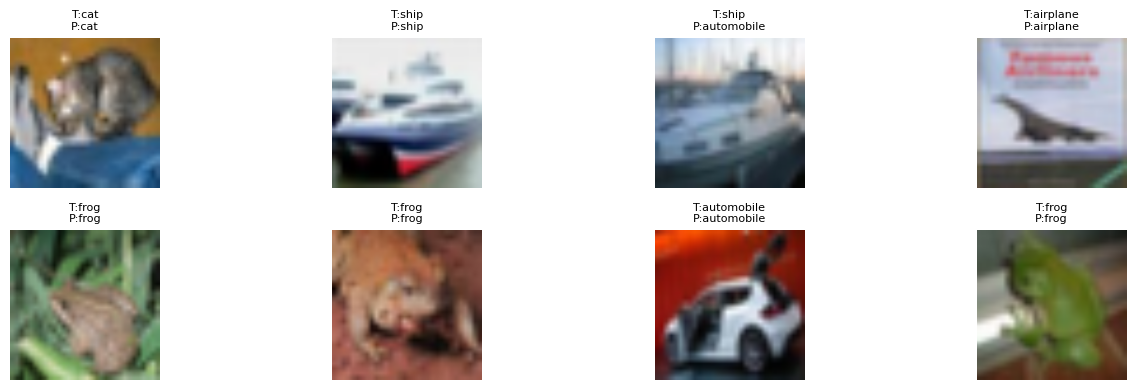

In [46]:
def show_examples(model, loader, n=8):
    model.eval()
    images, targets = next(iter(loader))
    images, targets = images.to(DEVICE), targets.to(DEVICE)

    with torch.no_grad():
        outputs = model(images)
        _, preds = outputs.max(1)

    images = images.cpu()
    preds = preds.cpu()
    targets = targets.cpu()

    classes = train_dataset.classes
    plt.figure(figsize=(14, 4))
    for i in range(n):
        img = images[i]
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        img = img + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)

        plt.subplot(2, n//2, i+1)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis("off")
        plt.title(f"T:{classes[targets[i]]}\nP:{classes[preds[i]]}", fontsize=8)

    plt.tight_layout()
    plt.show()

show_examples(model, test_loader, n=8)


In [48]:
import torch
import time

def measure_throughput(model, batch_size=128, img_size=224, steps=50, warmup=10):
    model.eval()
    model.to(DEVICE)

    dummy = torch.randn(batch_size, 3, img_size, img_size).to(DEVICE)

    # warmup
    for _ in range(warmup):
        with torch.no_grad():
            _ = model(dummy)

    # measure
    torch.cuda.synchronize()
    t0 = time.time()

    for _ in range(steps):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t1 = time.time()

    total_images = batch_size * steps
    throughput = total_images / (t1 - t0)
    return throughput

# ---- Load model (OCI or baseline) ---
model = build_fvit0_oci(pretrained_imagenet=False)
_, _ = load_checkpoint(BEST_CKPT, model)

throughput = measure_throughput(model)
print(f"Throughput (imgs/sec): {throughput:.2f}")


[OCI] Patching carrier conv in 'levels.2.global_tokenizer'
[OCI] Total carrier initializers patched: 1
[Checkpoint] Loading from /kaggle/working/fvit0_oci_cifar10/best.pt
Throughput (imgs/sec): 765.92


In [49]:
def measure_latency(model, img_size=224, warmup=10, runs=100):
    model.eval()
    model.to(DEVICE)

    dummy = torch.randn(1, 3, img_size, img_size).to(DEVICE)

    # warmup
    for _ in range(warmup):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t_start = time.time()

    for _ in range(runs):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t_end = time.time()

    latency_ms = (t_end - t_start) / runs * 1000
    return latency_ms

latency = measure_latency(model)
print(f"Latency (ms/image): {latency:.4f}")


Latency (ms/image): 27.0320


In [47]:
import shutil
from pathlib import Path

RUN_NAME = "fvit0_oci_cifar10"
CHECKPOINT_DIR = Path("/kaggle/working") / RUN_NAME

zip_base = Path("/kaggle/working") / f"{RUN_NAME}_artifacts"
zip_path = shutil.make_archive(
    base_name=str(zip_base),
    format="zip",
    root_dir=CHECKPOINT_DIR,   # only this folder gets zipped
)

print("Created zip:", zip_path)


Created zip: /kaggle/working/fvit0_oci_cifar10_artifacts.zip


# FasterVit0- Orginal model

In [6]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from fastervit import create_model

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ----- experiment config for BASELINE -----
RUN_NAME = "fvit0_baseline_cifar10"
CHECKPOINT_DIR = Path("/kaggle/working") / RUN_NAME
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

NUM_CLASSES = 10
BATCH_SIZE = 128          # keep same as OCI run
NUM_EPOCHS = 75           # you requested 75 epochs
BASE_LR = 5e-4
WEIGHT_DECAY = 0.05


Device: cuda


In [7]:
def build_fvit0_baseline(pretrained_imagenet: bool = False) -> nn.Module:
    """
    Plain FasterViT-0 for CIFAR-10 (no OCI).
    """
    model = create_model(
        "faster_vit_0_224",
        pretrained=pretrained_imagenet,  # usually False for CIFAR-10 from scratch
        num_classes=NUM_CLASSES,
    )
    return model.to(DEVICE)

model = build_fvit0_baseline(pretrained_imagenet=False)
print("Baseline params (M):", sum(p.numel() for p in model.parameters()) / 1e6)


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Baseline params (M): 30.89697


## raining loop for 75 epochs (with resume + checkpointing)

In [14]:
import os

def save_checkpoint(epoch, model, optimizer, scheduler, best_acc, path):
    state = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict() if scheduler is not None else None,
        "best_acc": best_acc,
    }
    torch.save(state, path)
    print(f"[Checkpoint] Saved to {path}")


def load_checkpoint(path, model, optimizer=None, scheduler=None):
    print(f"[Checkpoint] Loading from {path}")
    ckpt = torch.load(path, map_location=DEVICE)
    model.load_state_dict(ckpt["model_state"])
    if optimizer is not None and "optimizer_state" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer_state"])
    if scheduler is not None and ckpt.get("scheduler_state") is not None:
        scheduler.load_state_dict(ckpt["scheduler_state"])
    start_epoch = ckpt.get("epoch", 0) + 1
    best_acc = ckpt.get("best_acc", 0.0)
    return start_epoch, best_acc


def train_one_epoch(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, targets) in enumerate(loader):
        images = images.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    print(f"Train | Epoch {epoch} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion, epoch, split="Val"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, targets in loader:
        images = images.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    print(f"{split} | Epoch {epoch} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc


## Run training

In [15]:
def run_training_baseline(resume: bool = True):
    model = build_fvit0_baseline(pretrained_imagenet=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY
    )
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    ckpt_path = CHECKPOINT_DIR / "latest.pt"
    best_path = CHECKPOINT_DIR / "best.pt"

    start_epoch = 0
    best_acc = 0.0

    # resume if checkpoint exists
    if resume and ckpt_path.exists():
        start_epoch, best_acc = load_checkpoint(
            ckpt_path, model, optimizer, scheduler
        )
        print(f"Resuming from epoch {start_epoch}, best_acc={best_acc:.2f}%")

    for epoch in range(start_epoch, NUM_EPOCHS):
        train_one_epoch(model, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc = evaluate(model, test_loader, criterion, epoch, split="Val")

        scheduler.step()

        # save latest every epoch
        save_checkpoint(epoch, model, optimizer, scheduler, best_acc, ckpt_path)

        # save best model
        if val_acc > best_acc:
            best_acc = val_acc
            save_checkpoint(epoch, model, optimizer, scheduler, best_acc, best_path)
            print(f"[Best] New best accuracy: {best_acc:.2f}% at epoch {epoch}")

    print("Training finished. Best Val Acc: {:.2f}%".format(best_acc))


run_training_baseline(resume=True)


Train | Epoch 0 | Loss: 1.7756 | Acc: 32.32%
Val | Epoch 0 | Loss: 1.5153 | Acc: 42.97%
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/latest.pt
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/best.pt
[Best] New best accuracy: 42.97% at epoch 0
Train | Epoch 1 | Loss: 1.3947 | Acc: 49.11%
Val | Epoch 1 | Loss: 1.2842 | Acc: 53.61%
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/latest.pt
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/best.pt
[Best] New best accuracy: 53.61% at epoch 1
Train | Epoch 2 | Loss: 1.1639 | Acc: 58.20%
Val | Epoch 2 | Loss: 1.1226 | Acc: 59.86%
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/latest.pt
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/best.pt
[Best] New best accuracy: 59.86% at epoch 2
Train | Epoch 3 | Loss: 1.0394 | Acc: 63.01%
Val | Epoch 3 | Loss: 1.0494 | Acc: 63.91%
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/latest.pt
[Checkpoint] Saved to /kaggle/working/fvit0_oci_cifar10/best

## Evaluation for baseline: accuracy, JSON, confusion matrix, examples

In [23]:
import json

BEST_CKPT_BASE = CHECKPOINT_DIR / "best.pt"
print("Baseline best checkpoint path:", BEST_CKPT_BASE)

# rebuild baseline model & load best weights
model_base = build_fvit0_baseline(pretrained_imagenet=False)
criterion = nn.CrossEntropyLoss()

start_epoch_base, best_acc_saved_base = load_checkpoint(
    BEST_CKPT_BASE,
    model_base,
    optimizer=None,
    scheduler=None,
)

print(f"[Baseline] Best val acc from ckpt: {best_acc_saved_base:.2f}% (epoch {start_epoch_base-1})")

# final TEST evaluation
test_loss_base, test_acc_base = evaluate(
    model_base,
    test_loader,
    criterion,
    epoch="best",
    split="Test (Baseline)"
)

print(f"[FasterViT-0 BASELINE] Final Test Acc: {test_acc_base:.2f}%, Test Loss: {test_loss_base:.4f}")

# save numeric results
results_base = {
    "model": "fvit0_baseline_cifar10",
    "ckpt_epoch": int(start_epoch_base - 1),
    "val_best_acc": float(best_acc_saved_base),
    "test_loss": float(test_loss_base),
    "test_acc": float(test_acc_base),
}

results_path_base = CHECKPOINT_DIR / "results_baseline.json"
with open(results_path_base, "w") as f:
    json.dump(results_base, f, indent=2)

print("Saved baseline results to", results_path_base)


Baseline best checkpoint path: /kaggle/working/fvit0_oci_cifar10/best.pt
[Checkpoint] Loading from /kaggle/working/fvit0_oci_cifar10/best.pt
[Baseline] Best val acc from ckpt: 92.65% (epoch 72)
Test (Baseline) | Epoch best | Loss: 0.3038 | Acc: 92.65%
[FasterViT-0 BASELINE] Final Test Acc: 92.65%, Test Loss: 0.3038
Saved baseline results to /kaggle/working/fvit0_oci_cifar10/results_baseline.json


## Confusion matrix for baseline

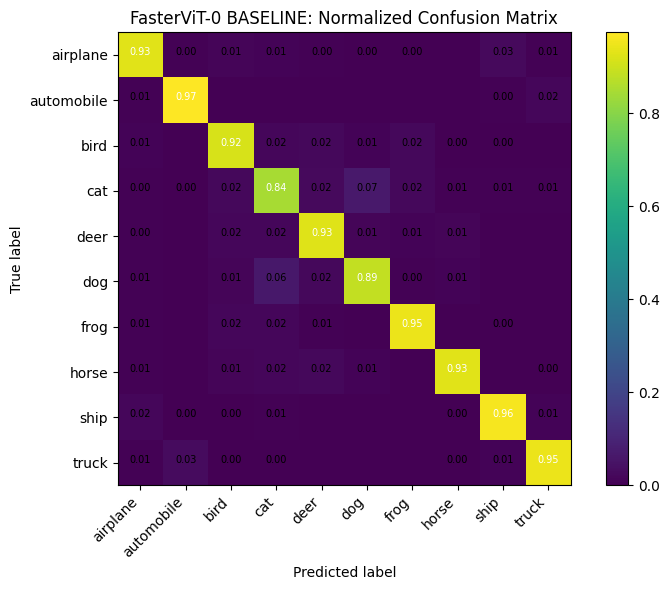

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

model_base.eval()
model_base.to(DEVICE)

all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model_base(images)
        _, preds = outputs.max(1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

cm = confusion_matrix(all_targets, all_preds)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

classes = train_dataset.classes  # CIFAR-10 labels

plt.figure(figsize=(8, 6))
plt.imshow(cm_norm, interpolation='nearest')
plt.title("FasterViT-0 BASELINE: Normalized Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha="right")
plt.yticks(tick_marks, classes)

thresh = cm_norm.max() / 2.
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    val = cm_norm[i, j]
    if val > 0.001:
        plt.text(j, i, f"{val:.2f}",
                 horizontalalignment="center",
                 color="white" if val > thresh else "black",
                 fontsize=7)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


## Example predictions (baseline)

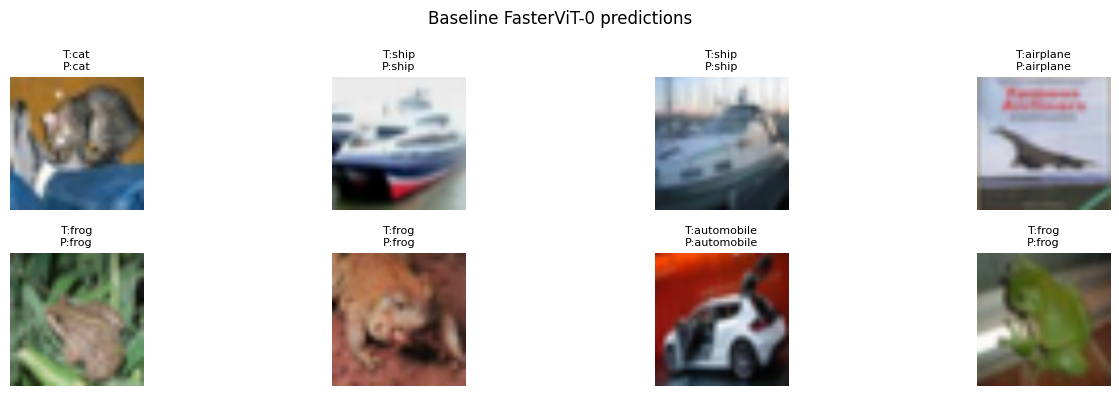

In [20]:
def show_examples(model, loader, n=8, title_prefix="Baseline"):
    model.eval()
    images, targets = next(iter(loader))
    images, targets = images.to(DEVICE), targets.to(DEVICE)

    with torch.no_grad():
        outputs = model(images)
        _, preds = outputs.max(1)

    images = images.cpu()
    preds = preds.cpu()
    targets = targets.cpu()

    classes = train_dataset.classes
    plt.figure(figsize=(14, 4))
    for i in range(n):
        img = images[i]
        # un-normalize for display
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        img = img + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)

        plt.subplot(2, n//2, i+1)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis("off")
        plt.title(f"T:{classes[targets[i]]}\nP:{classes[preds[i]]}", fontsize=8)

    plt.suptitle(f"{title_prefix} predictions", fontsize=12)
    plt.tight_layout()
    plt.show()

show_examples(model_base, test_loader, n=8, title_prefix="Baseline FasterViT-0")


## Throughput & latency for baseline

In [21]:
import time

def measure_throughput(model, batch_size=128, img_size=224, steps=50, warmup=10):
    model.eval()
    model.to(DEVICE)
    dummy = torch.randn(batch_size, 3, img_size, img_size).to(DEVICE)

    # warmup
    for _ in range(warmup):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t0 = time.time()

    for _ in range(steps):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t1 = time.time()

    total_images = batch_size * steps
    throughput = total_images / (t1 - t0)
    return throughput


def measure_latency(model, img_size=224, warmup=10, runs=100):
    model.eval()
    model.to(DEVICE)
    dummy = torch.randn(1, 3, img_size, img_size).to(DEVICE)

    # warmup
    for _ in range(warmup):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t_start = time.time()

    for _ in range(runs):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t_end = time.time()

    latency_ms = (t_end - t_start) / runs * 1000
    return latency_ms

throughput_base = measure_throughput(model_base)
latency_base = measure_latency(model_base)

print(f"[Baseline] Throughput: {throughput_base:.2f} imgs/sec")
print(f"[Baseline] Latency: {latency_base:.4f} ms/image")

[Baseline] Throughput: 788.72 imgs/sec
[Baseline] Latency: 27.0718 ms/image


# Comparison with your OCI model

In [22]:
import json
from pathlib import Path

# load OCI results
results_oci_path = Path("/kaggle/working/fvit0_oci_cifar10/results_oci.json")
with open(results_oci_path, "r") as f:
    res_oci = json.load(f)

# baseline results we just saved
with open(results_path_base, "r") as f:
    res_base = json.load(f)

print("=== Accuracy comparison (Test) ===")
print(f"Baseline FasterViT-0 test acc: {res_base['test_acc']:.2f}%")
print(f"FasterViT-0 + OCI   test acc: {res_oci['test_acc']:.2f}%")

print("\n=== Val best acc comparison ===")
print(f"Baseline best val acc: {res_base['val_best_acc']:.2f}%")
print(f"OCI best val acc     : {res_oci['val_best_acc']:.2f}%")

# If you also ran throughput/latency for OCI, put them manually here:
throughput_oci = ...   # fill after measuring
latency_oci = ...      # fill after measuring

print("\n=== Speed comparison ===")
print(f"Baseline throughput: {throughput_base:.2f} imgs/sec")
print(f"OCI throughput     : {throughput_oci:.2f} imgs/sec")

print(f"Baseline latency  : {latency_base:.4f} ms/img")
print(f"OCI latency       : {latency_oci:.4f} ms/img")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/fvit0_oci_cifar10/results_oci.json'

## all

In [ ]:
# =========================
# Full comparison script
# Baseline vs OCI
# =========================
import json
import time
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import torch
import torch.nn as nn

# --------- paths & basic setup ----------
RUN_NAME_BASE = "fvit0_baseline_cifar10"
RUN_NAME_OCI  = "fvit0_oci_cifar10"

BASE_DIR = Path("/kaggle/working")
CKPT_BASE = BASE_DIR / RUN_NAME_BASE / "best.pt"
CKPT_OCI  = BASE_DIR / RUN_NAME_OCI  / "best.pt"

print("Baseline ckpt:", CKPT_BASE)
print("OCI ckpt     :", CKPT_OCI)

criterion = nn.CrossEntropyLoss()


# --------- speed measurement helpers ----------
def measure_throughput(model, batch_size=128, img_size=224, steps=50, warmup=10):
    model.eval()
    model.to(DEVICE)
    dummy = torch.randn(batch_size, 3, img_size, img_size).to(DEVICE)

    # warmup
    for _ in range(warmup):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t0 = time.time()

    for _ in range(steps):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t1 = time.time()

    total_images = batch_size * steps
    throughput = total_images / (t1 - t0)
    return throughput


def measure_latency(model, img_size=224, warmup=10, runs=100):
    model.eval()
    model.to(DEVICE)
    dummy = torch.randn(1, 3, img_size, img_size).to(DEVICE)

    # warmup
    for _ in range(warmup):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t_start = time.time()

    for _ in range(runs):
        with torch.no_grad():
            _ = model(dummy)

    torch.cuda.synchronize()
    t_end = time.time()

    latency_ms = (t_end - t_start) / runs * 1000
    return latency_ms


# --------- full eval (acc + confusion + speed) ----------
@torch.no_grad()
def eval_model_full(model, loader, name="model"):
    model.eval()
    model.to(DEVICE)

    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    for images, targets in loader:
        images = images.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()

        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    test_loss = running_loss / total
    test_acc = 100.0 * correct / total

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    cm = confusion_matrix(all_targets, all_preds)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    print(f"[{name}] Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    # speed
    throughput = measure_throughput(model)
    latency = measure_latency(model)
    print(f"[{name}] Throughput: {throughput:.2f} imgs/sec | Latency: {latency:.4f} ms/img")

    metrics = {
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "throughput": float(throughput),
        "latency_ms": float(latency),
    }

    return metrics, cm_norm


# --------- load both models ----------
# Baseline
model_base = build_fvit0_baseline(pretrained_imagenet=False)
_, best_acc_base = load_checkpoint(
    CKPT_BASE, model_base, optimizer=None, scheduler=None
)

# OCI
model_oci = build_fvit0_oci(pretrained_imagenet=False)
_, best_acc_oci = load_checkpoint(
    CKPT_OCI, model_oci, optimizer=None, scheduler=None
)

print(f"Loaded baseline (best val acc from ckpt: {best_acc_base:.2f}%)")
print(f"Loaded OCI      (best val acc from ckpt: {best_acc_oci:.2f}%)")

# --------- run full eval for both ----------
metrics_base, cm_base = eval_model_full(model_base, test_loader, name="Baseline FasterViT-0")
metrics_oci,  cm_oci  = eval_model_full(model_oci,  test_loader, name="FasterViT-0 + OCI")


# --------- plot confusion matrices side-by-side ----------
classes = train_dataset.classes  # CIFAR-10 labels

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, cm_norm, title in zip(
    axes,
    [cm_base, cm_oci],
    ["Baseline FasterViT-0", "FasterViT-0 + OCI"],
):
    im = ax.imshow(cm_norm, interpolation='nearest')
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        val = cm_norm[i, j]
        if val > 0.001:
            ax.text(j, i, f"{val:.2f}",
                    horizontalalignment="center",
                    color="white" if val > thresh else "black",
                    fontsize=7)

    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.tight_layout()
plt.show()


# --------- save all comparison metrics to one JSON ----------
comparison = {
    "baseline": {
        "val_best_acc": float(best_acc_base),
        **metrics_base,
    },
    "oci": {
        "val_best_acc": float(best_acc_oci),
        **metrics_oci,
    },
}

comp_path = BASE_DIR / "fvit0_baseline_vs_oci_comparison.json"
with open(comp_path, "w") as f:
    json.dump(comparison, f, indent=2)

print("\nSaved full comparison metrics to:", comp_path)
print("\nSummary:")
print("Baseline  - Test Acc: {:.2f}%, Throughput: {:.2f} imgs/s, Latency: {:.4f} ms".format(
    metrics_base["test_acc"], metrics_base["throughput"], metrics_base["latency_ms"]
))
print("OCI       - Test Acc: {:.2f}%, Throughput: {:.2f} imgs/s, Latency: {:.4f} ms".format(
    metrics_oci["test_acc"], metrics_oci["throughput"], metrics_oci["latency_ms"]
))
